# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


# Parameters

In [4]:
m=1
p = 3
q = 0.0 #Pure SF is q=0
run = 1

1

Choose your grid

In [5]:
global compactified=false
global loggrid=false
global bisection=false
global zeroformat=false

false

In [6]:
using Quadmath, Printf

res=m;
N=2.0^m*200.0/2.0

if compactified==true
    Xf=1.0
else
    Xf=10.0
end

dx=Xf/N
if loggrid==false
    dt=0.5*round(dx,digits=10)
else
    dt=0.1*round(dx,digits=10)
end
Nt=2.0^m*200.0/2.0
Tf=Nt*dt;

In [7]:
print(N)

200.0

In [8]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/YangMills/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/YangMills/DATA"

# Grid

In [9]:
using Printf
include("./YangMills.jl");

In [10]:
ori=0.0#Float128(0.0)#0.0;
initX1 = nothing
N=int(N)
initX1=range(ori, stop=Xf, step=dx);
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)
println("the time step is ", dt)

if loggrid==true
    global originalX=initX
    xtilde=gridfunc(initX1)
    initX1=xtilde
    initX=collect(initX)
    initX[4:L-3]=xtilde
end;

step size is  0.05
the time step is 0.025


# Initial data of m β Ψ and Ψ,x

In [11]:
using Dierckx


####

initm=zeros(L)
initbeta=zeros(L)
initpsi=zeros(L)
initrchi=zeros(L)
initderrchiu=zeros(L)
initderpsi=zeros(L)
initderrchir=zeros(L)


#state array is m beta psi rchi rchi,u psi,r rchi,r r
state_array=[initm initbeta initpsi initrchi initderrchiu initderpsi initderrchir initX];

#PSI,R
A=0.075*p*(1−q)
r0=0.75
sigma=0.25

initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)

state_array[:,6] = initderpsi
state_array=ghost(state_array)

#CHI,R
A=0.25*p*q
r0=0.3
sigma=0.1

initderrchir[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)

state_array[:,7] = initderrchir

####
#PSI FROM PSI,R
derpsi_func = Spline1D(initX[4:L-3], state_array[4:L-3,6],  k=4);
derrchir_func = Spline1D(initX[4:L-3], state_array[4:L-3,7],  k=4);

funcs=[derpsi_func derrchir_func];

In [12]:
y0=[0.0 0.0 0.0 0.0 0.0]

state_array[4:L-3,1:5] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,funcs,state_array[:,:]);

#state_array = ghost(state_array);

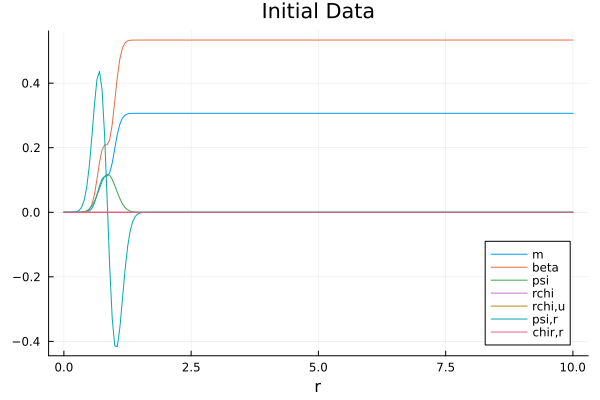

In [13]:
using Plots #showing initial data and the initial status of the horizon finder
plot((initX[4:L-3]), state_array[4:L-3,1:7], xaxis="r",title="Initial Data", labels=["m" "beta" "psi" "rchi" "rchi,u" "psi,r" "chir,r"])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [14]:
using CSV, Tables
#CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

global files=["m", "beta", "psi", "rchi", "derurchi", "derpsi", "derrchi"]

print_muninn(files, 0, state_array[:,:],res,"w")

In [15]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
global monitor_ratio = zeros(L);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

In [16]:
ginit=speed(initX,state_array[:,1],state_array[:,2])
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

0.005536943007046599


In [17]:
using Base.Threads
Threads.nthreads()

4

In [18]:
if m==1
    global dt=2e-5
elseif m==2
    global dt=1e-5
else
    global dt=1e-5/2
end

2.0e-5

 ## Time evolution

fixed grid

In [19]:
finaltime=3.0
evol_stats, T_interp = timeevolution(state_array,finaltime,run);
#CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=false);



iteration 100 dt is 0.00013840570574229653, t=0.013841463886560552 speed is 180.6283914808293, dx/dt=361.2567829616586


iteration 200 dt is 0.0001383876764995872, t=0.027681123802069156 speed is 180.6519238732545, dx/dt=361.303847746509


iteration 300 dt is 0.00013836967005562375, t=0.04151898192887125 speed is 180.67543262877012, dx/dt=361.35086525754025


iteration 400 dt is 0.00013835168820380218, t=0.05535504063901523 speed is 180.6989153841995, dx/dt=361.397830768399


iteration 500 dt is 0.00013833373256498925, t=0.06918930247484985 speed is 180.7223699993419, dx/dt=361.4447399986838


iteration 600 dt is 0.00013831580462149535, t=0.08302177013357039 speed is 180.74579451287673, dx/dt=361.49158902575346


iteration 700 dt is 0.0001382979057423944, t=0.09685244645470327 speed is 180.76918710950807, dx/dt=361.53837421901613


iteration 800 dt is 0.0001382800372024647, t=0.11068133440978443 speed is 180.7925460953984, dx/dt=361.58509219079673


iteration 900 dt is 0.000138262200



iteration 6900 dt is 0.00013727448315834976, t=0.9510279395907688 speed is 182.1168758010317, dx/dt=364.2337516020634


iteration 7000 dt is 0.0001372596839182322, t=0.9647546400039854 speed is 182.13651151122355, dx/dt=364.27302302244703


iteration 7100 dt is 0.0001372449499874623, t=0.9784798637848937 speed is 182.15606477530736, dx/dt=364.3121295506147


iteration 7200 dt is 0.00013723028214690885, t=0.9922036175036864 speed is 182.17553450219393, dx/dt=364.35106900438785


iteration 7300 dt is 0.00013721568119828755, t=1.0059259078097 speed is 182.19491957244315, dx/dt=364.3898391448863


iteration 7400 dt is 0.00013720114796367461, t=1.0196467414334758 speed is 182.2142188388905, dx/dt=364.428437677781


iteration 7500 dt is 0.00013718668328493026, t=1.0333661251887662 speed is 182.23343112739434, dx/dt=364.46686225478874


iteration 7600 dt is 0.0001371722880230355, t=1.0470840659744813 speed is 182.25255523770022, dx/dt=364.5051104754004


iteration 7700 dt is 0.0001371579630



iteration 13700 dt is 0.00013646030333517843, t=1.8814821457001465 speed is 183.2034620251001, dx/dt=366.4069240502002


iteration 13800 dt is 0.0001364517028469432, t=1.8951277409036795 speed is 183.21500925526965, dx/dt=366.4300185105393


iteration 13900 dt is 0.0001364431985219994, t=1.9087724809227924 speed is 183.22642880560386, dx/dt=366.4528576112078


iteration 14000 dt is 0.00013643478935494824, t=1.9224163753234802 speed is 183.23772197837383, dx/dt=366.47544395674765


iteration 14100 dt is 0.00013642647428865735, t=1.9360594335685708 speed is 183.24889014652584, dx/dt=366.4977802930517


iteration 14200 dt is 0.00013641825221588798, t=1.9497016650126342 speed is 183.25993475151978, dx/dt=366.51986950303956


iteration 14300 dt is 0.00013641012198105224, t=1.9633430788970632 speed is 183.27085730098955, dx/dt=366.5417146019791


iteration 14400 dt is 0.0001364020823821171, t=1.976983684345325 speed is 183.28165936620343, dx/dt=366.56331873240686


iteration 14500 dt is 0.



iteration 20500 dt is 0.00013603006923840162, t=2.8078057257368236 speed is 183.78289550221328, dx/dt=367.56579100442656


iteration 20600 dt is 0.00013602539848287318, t=2.821408496353167 speed is 183.7892061249703, dx/dt=367.57841224994064


iteration 20700 dt is 0.00013602078069583192, t=2.8350108025547396 speed is 183.79544560845235, dx/dt=367.5908912169047


iteration 20800 dt is 0.00013601621761325923, t=2.848612649725382 speed is 183.80161159225568, dx/dt=367.60322318451136


iteration 20900 dt is 0.0001360117110505443, t=2.8622140434265737 speed is 183.80770160820614, dx/dt=367.6154032164123


iteration 21000 dt is 0.00013600726289937477, t=2.875814989405203 speed is 183.81371308454533, dx/dt=367.62742616909065


iteration 21100 dt is 0.00013600287512440678, t=2.889415493601049 speed is 183.8196433504188, dx/dt=367.6392867008376


iteration 21200 dt is 0.00013599854975971905, t=2.9030155621538882 speed is 183.82548964065987, dx/dt=367.65097928131974


iteration 21300 dt is 0.

#### 

 ## Movie of the evolution, apparent horizon formation for 0.0492<A*<0.04925

In [336]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 710:710
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    temp=round(n*dt,digits=2)
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"], title="$temp", ylim=[-0.01, 0.01],xlim=[0.0, 0.1])#, xlim=[0, 0.1])# |> display 
    
    end

gif(anim, "N2000_A$A.gif", fps = 15000)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/YangMills/DATA/res1/time_step710.csv" is not a valid file or doesn't exist

In [49]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 8000:100:10000
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot6=functions3.Column1[4:L-3] .* 2 .* (1 .- functions3.Column5[4:L-3]) ./functions3.Column5[4:L-3];
    
    
    plot!(initX1, plot6, labels=["monitor ratio"], ylim=[-1.3, 0.6],xlim=[0.0, 0.3])#, xlim=[0, 0.1])# |> display 
    
    end

gif(anim, "N2000_A$A.gif", fps = 15000)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step8000.csv" is not a valid file or doesn't exist

In [50]:
dir

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

In [141]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 8200:5:8430
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1],xlim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 1500)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/monitor_ratio8200.csv" is not a valid file or doesn't exist

Sanity check for der func

In [207]:
array=init_gaussian(originalX,0.7,0.3,0.01)
arrayloggrid=init_gaussian(initX,0.7,0.3,0.01);

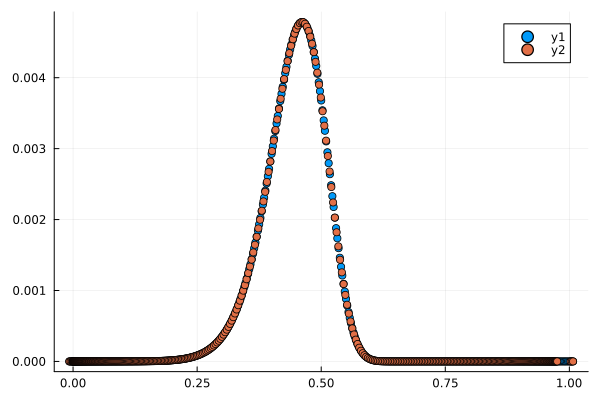

In [209]:
scatter([originalX, initX], [array, arrayloggrid])

In [210]:
aux=zeros(L)

loggrid=false
for i in 4:L-3
    aux[i]=Dertest(array,i,originalX)
end
x1=originalX
y1=aux


loggrid=true
for i in 4:L-3
    aux[i]=Dertest(arrayloggrid,i,initX)
end
x2=initX
y2=aux;

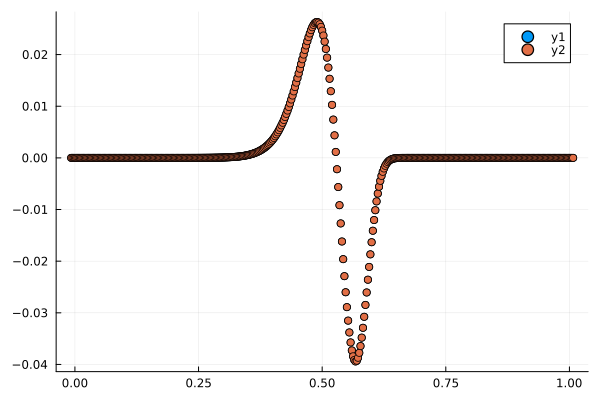

In [417]:
scatter([x1,x1],[y1,y2])